In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os

In [2]:
path = "./Data_Individual_Component/original_retinal_images/"
files = os.listdir(path)

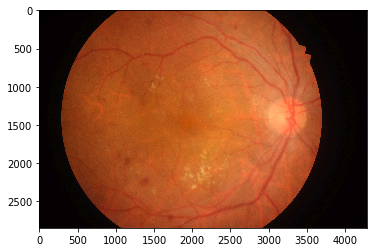

In [3]:
img = cv2.imread(path+files[0], 1)
img_show = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.imshow(img_show)

In [4]:
# cite: https://blog.csdn.net/qq_30091945/article/details/78236347
def RGB2HSI(rgb_img):
    """
    这是将RGB彩色图像转化为HSI图像的函数
    :param rgm_img: RGB彩色图像
    :return: HSI图像
    """
    #保存原始图像的行列数
    row = np.shape(rgb_img)[0]
    col = np.shape(rgb_img)[1]
    #对原始图像进行复制
    hsi_img = rgb_img.copy()
    #对图像进行通道拆分
    B,G,R = cv2.split(rgb_img)
    #把通道归一化到[0,1]
    [B,G,R] = [ i/ 255.0 for i in ([B,G,R])]
    H = np.zeros((row, col))    #定义H通道
    I = (R + G + B) / 3.0       #计算I通道
    S = np.zeros((row,col))      #定义S通道
    for i in range(row):
        den = np.sqrt((R[i]-G[i])**2+(R[i]-B[i])*(G[i]-B[i]))
        thetha = np.arccos(0.5*(R[i]-B[i]+R[i]-G[i])/den)   #计算夹角
        h = np.zeros(col)               #定义临时数组
        #den>0且G>=B的元素h赋值为thetha
        h[B[i]<=G[i]] = thetha[B[i]<=G[i]]
        #den>0且G<=B的元素h赋值为thetha
        h[G[i]<B[i]] = 2*np.pi-thetha[G[i]<B[i]]
        #den<0的元素h赋值为0
        h[den == 0] = 0
        H[i] = h/(2*np.pi)      #弧度化后赋值给H通道
    #计算S通道
    for i in range(row):
        min = []
        #找出每组RGB值的最小值
        for j in range(col):
            arr = [B[i][j],G[i][j],R[i][j]]
            min.append(np.min(arr))
        min = np.array(min)
        #计算S通道
        S[i] = 1 - min*3/(R[i]+B[i]+G[i])
        #I为0的值直接赋值0
        S[i][R[i]+B[i]+G[i] == 0] = 0
    #扩充到255以方便显示，一般H分量在[0,2pi]之间，S和I在[0,1]之间
    hsi_img[:,:,0] = H*255
    hsi_img[:,:,1] = S*255
    hsi_img[:,:,2] = I*255
    return hsi_img

def HSI2RGB(hsi_img):
    """
    这是将HSI图像转化为RGB图像的函数
    :param hsi_img: HSI彩色图像
    :return: RGB图像
    """
    # 保存原始图像的行列数
    row = np.shape(hsi_img)[0]
    col = np.shape(hsi_img)[1]
    #对原始图像进行复制
    rgb_img = hsi_img.copy()
    #对图像进行通道拆分
    H,S,I = cv2.split(hsi_img)
    #把通道归一化到[0,1]
    [H,S,I] = [ i/ 255.0 for i in ([H,S,I])]
    R,G,B = H,S,I
    for i in range(row):
        h = H[i]*2*np.pi
        #H大于等于0小于120度时
        a1 = h >=0
        a2 = h < 2*np.pi/3
        a = a1 & a2         #第一种情况的花式索引
        tmp = np.cos(np.pi / 3 - h)
        b = I[i] * (1 - S[i])
        r = I[i]*(1+S[i]*np.cos(h)/tmp)
        g = 3*I[i]-r-b
        B[i][a] = b[a]
        R[i][a] = r[a]
        G[i][a] = g[a]
        #H大于等于120度小于240度
        a1 = h >= 2*np.pi/3
        a2 = h < 4*np.pi/3
        a = a1 & a2         #第二种情况的花式索引
        tmp = np.cos(np.pi - h)
        r = I[i] * (1 - S[i])
        g = I[i]*(1+S[i]*np.cos(h-2*np.pi/3)/tmp)
        b = 3 * I[i] - r - g
        R[i][a] = r[a]
        G[i][a] = g[a]
        B[i][a] = b[a]
        #H大于等于240度小于360度
        a1 = h >= 4 * np.pi / 3
        a2 = h < 2 * np.pi
        a = a1 & a2             #第三种情况的花式索引
        tmp = np.cos(5 * np.pi / 3 - h)
        g = I[i] * (1-S[i])
        b = I[i]*(1+S[i]*np.cos(h-4*np.pi/3)/tmp)
        r = 3 * I[i] - g - b
        B[i][a] = b[a]
        G[i][a] = g[a]
        R[i][a] = r[a]
    rgb_img[:,:,0] = B*255
    rgb_img[:,:,1] = G*255
    rgb_img[:,:,2] = R*255
    return rgb_img

## preprocessing: RGB -> IHS -> CLAHE()

In [5]:
img = RGB2HSI(img[:,500:3500])

C:\Users\huyir\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide
C:\Users\huyir\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in arccos


In [6]:
h, s, i = cv2.split(img)
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
i = clahe.apply(i)
img = cv2.merge([h,s,i])

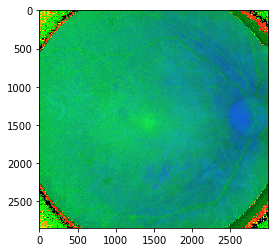

In [7]:
plt.imshow(img)

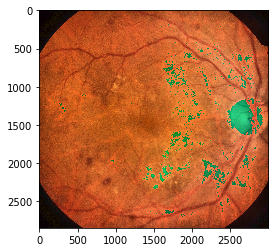

In [8]:
img_show = HSI2RGB(img)
img_show = cv2.cvtColor(img_show,cv2.COLOR_BGR2RGB)
plt.imshow(img_show)

# recursive region growing segmentation

In [9]:
from PIL import Image

In [10]:
# RRGS
class Point(object):
    def __init__(self,x,y):
        self.x = x
        self.y = y
 
    def getX(self):
        return self.x
    def getY(self):
        return self.y
 
def getGrayDiff(img,currentPoint,tmpPoint):
    return abs(int(img[currentPoint.x,currentPoint.y]) - int(img[tmpPoint.x,tmpPoint.y]))
 
def selectConnects():
    connects = [Point(0, -1), Point(1, 0), Point(0, 1), Point(-1, 0)]#4邻域
    return connects
 
def regionGrow(img,seeds,thresh):
    height, weight = img.shape
    seedMark = np.zeros(img.shape)
    seedList = []
    
    for seed in seeds:
        seedList.append(seed)
    label = 1
    connects = selectConnects()
    
    while(len(seedList)>0):
        currentPoint = seedList.pop(0)
        seedMark[currentPoint.x,currentPoint.y] = label
        for i in range(4):
            tmpX = currentPoint.x + connects[i].x
            tmpY = currentPoint.y + connects[i].y
            if tmpX < 0 or tmpY < 0 or tmpX >= height or tmpY >= weight:
                continue
            grayDiff = getGrayDiff(img,currentPoint,Point(tmpX,tmpY))
            if grayDiff <= thresh and seedMark[tmpX,tmpY] == 0:
                seedMark[tmpX,tmpY] = label
                seedList.append(Point(tmpX,tmpY))
    return seedMark

In [11]:
h,s,i = cv2.split(img)
seed = [Point(1500,1500)]

In [12]:
cv2.imwrite('hsi.jpg',img)

True

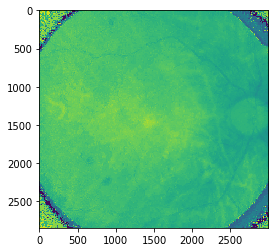

In [43]:
img2 = cv2.imread('hsi.jpg', 0)
plt.imshow(img2)

In [44]:
cv2.imwrite('hsi_gray.jpg',img2)

True

In [45]:
cv2.imwrite('hsi_I.jpg', i)

True

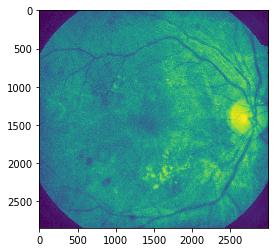

In [46]:
plt.imshow(i)

In [17]:
seedmark = regionGrow(i, seed, 10) # hsi的i通道

In [18]:
seedmark2 = regionGrow(img2, seed, 10) # hsi的灰度图

In [19]:
np.where(seedmark==1)

(array([   0,    0,    0, ..., 2847, 2847, 2847], dtype=int64),
 array([   0,    1,    2, ..., 2997, 2998, 2999], dtype=int64))

In [20]:
np.where(seedmark2==1)

(array([   0,    0,    0, ..., 2847, 2847, 2847], dtype=int64),
 array([ 544,  545,  546, ..., 2411, 2412, 2413], dtype=int64))

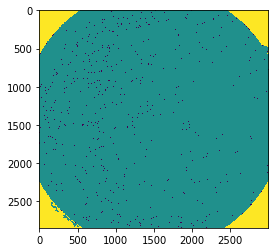

In [26]:
plt.imshow(seedmark - seedmark2)

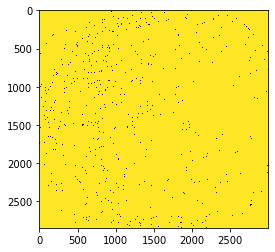

In [21]:
plt.imshow(seedmark)

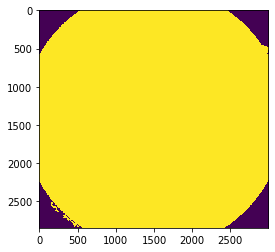

In [22]:
plt.imshow(seedmark2)

In [23]:
average1 = int(np.sum(i[np.where(seedmark==1)])/(img.shape[0]*img.shape[1]))
average2 = int(np.sum(img2[np.where(seedmark2==1)])/(img2.shape[0]*img2.shape[1]))
print(average1, average2)

105 121


In [27]:
median1 = np.median(i.ravel())
median2 = np.median(img2.ravel())
print(median1, median2)

109.0 130.0


In [31]:
i_1 = np.array(np.where(seedmark==1, median1, i),dtype=np.uint8)
i_1

array([[109, 109, 109, ..., 109, 109, 109],
       [109, 109, 109, ..., 109, 109, 109],
       [109, 109, 109, ..., 109, 109, 109],
       ...,
       [109, 109, 109, ..., 109, 109, 109],
       [109, 109, 109, ..., 109, 109, 109],
       [109, 109, 109, ..., 109, 109, 109]], dtype=uint8)

In [32]:
seg1 = cv2.merge([h,s,i_1])
seg2 = np.array(np.where(seedmark2==1, median2, img2))

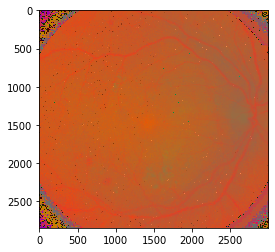

In [33]:
seg1_show = HSI2RGB(seg1)
img_show = cv2.cvtColor(seg1_show,cv2.COLOR_BGR2RGB)
plt.imshow(img_show)

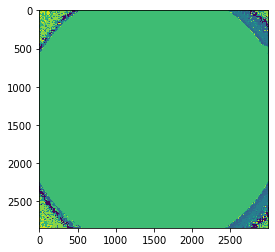

In [34]:
plt.imshow(seg2)

In [36]:
thresh1 = np.argmax(np.bincount(i.flatten()))
thresh2 = np.argmax(np.bincount(img2.flatten()))
print(thresh1, thresh2)

110 135


In [52]:
_, i_2 = cv2.threshold(i, thresh1, 255, cv2.THRESH_BINARY)
_, seg2_2 = cv2.threshold(img2, thresh2, 255, cv2.THRESH_BINARY)

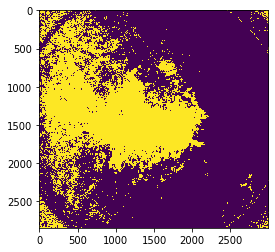

In [53]:
plt.imshow(seg2_2)

In [54]:
seg1_2 = cv2.merge([h,s,i_2])

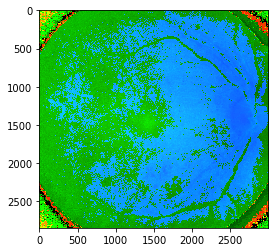

In [55]:
plt.imshow(seg1_2)

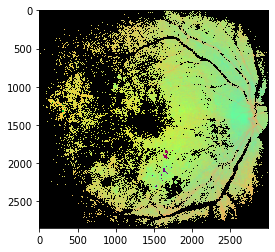

In [56]:
seg1_show = HSI2RGB(seg1_2)
img_show = cv2.cvtColor(seg1_show,cv2.COLOR_BGR2RGB)
plt.imshow(img_show)

In [57]:
cv2.imwrite('seg.jpg',seg1_2)

True

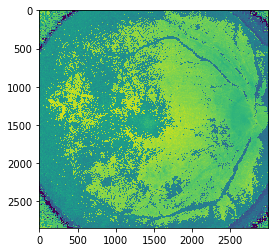

In [58]:
img = cv2.imread('seg.jpg', 0)
plt.imshow(img)